In [145]:
import numpy as np
import pandas as pd
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from collections import Counter
import matplotlib.pyplot as plt

In [146]:
voteData = pd.read_csv("dataset/house_votes_84.csv")

In [147]:
def splitDataset(dataset):
    feature = dataset.values[:, :-1] 
    label = dataset.values[:, -1]
    feature_train, feature_test, label_train, label_test = train_test_split(feature, label, test_size=0.2)
    
    return feature_train, feature_test, label_train, label_test

In [148]:
class Node:
    def __init__(self, value=None, featureName=None, majorityLabel=None):
        self.value = value
        self.featureName = featureName
        self.children = {}
        self.majorityLabel = majorityLabel

In [149]:
def calculateEntropy(labels):
    numClasses = Counter(labels)
    entropy = 0
    instanceCount = len(labels)
    
    for count in numClasses.values():
        probability = count / instanceCount
        entropy -= probability * np.log2(probability)

    return entropy

In [150]:
def calculateGini(labels):
    class_counts = Counter(labels)
    instances = len(labels)
    impurity = 1 - sum((count/instances)**2 for count in class_counts.values())
    
    return impurity

In [151]:
def calculateInfoGain(dataset, partitions, netDatasetEntropy):
    return netDatasetEntropy - sum([(len(partition) / len(dataset)) * calculateEntropy(partition[:, -1]) for partition in partitions])

In [152]:
def calculateWeightedGini(partitions, dataset):
    return sum([(len(partition) / len(dataset)) * calculateGini(partition[:, -1]) for partition in partitions])

In [153]:
def selectAttribute(dataset, attributeList, attributeNames, criterion='infoGain'):
    bestMeasure = float("inf") if criterion == 'giniIndex' else -1
    bestAttributeIdx = None
    
    for attributeIdx in attributeList:
        uniqueAttributes = np.unique(dataset[:, attributeIdx])
        partitions = [dataset[dataset[:, attributeIdx] == value] for value in uniqueAttributes]
        
        if criterion == 'infoGain':
            netDatasetEntropy = calculateEntropy(dataset[:, -1])
            measure = calculateInfoGain(dataset, partitions, netDatasetEntropy)
            if measure > bestMeasure:
                bestMeasure = measure
                bestAttributeIdx = attributeIdx
        elif criterion == 'giniIndex':
            weightedGini = calculateWeightedGini(partitions, dataset)
            if weightedGini < bestMeasure:
                bestMeasure = weightedGini
                bestAttributeIdx = attributeIdx

    return bestAttributeIdx, attributeNames[bestAttributeIdx]

In [154]:
def buildDecisionTree(dataset, attributeList, attributeNames, criterion, depthControl):
    majorityLabel, majorityCount = Counter(dataset[:, -1]).most_common(1)[0]
    totalInstances = len(dataset[:, -1])
    
    # Depth control based on majority class proportion
    if depthControl and majorityCount / totalInstances > 0.85:
        return Node(value=majorityLabel, majorityLabel=majorityLabel)
    
    # If all the labels are the same or there are no more attributes to test
    if len(np.unique(dataset[:, -1])) == 1 or not attributeList:
        return Node(value=majorityLabel, majorityLabel=majorityLabel)
    
    # select the best attribute depending on the selection criteria
    bestAttributeIdx, bestAttributeName = selectAttribute(dataset, attributeList, attributeNames, criterion)
    node = Node(featureName=bestAttributeName, majorityLabel=majorityLabel)

    uniqueAttributes = np.unique(dataset[:, bestAttributeIdx])
    attributeListCopy = attributeList.copy()
    attributeListCopy.remove(bestAttributeIdx)

    for value in uniqueAttributes:
        partition = dataset[dataset[:, bestAttributeIdx] == value]
        if partition.size == 0:
            node.children[value] = Node(value=majorityLabel, majorityLabel=majorityLabel)
        else:
            node.children[value] = buildDecisionTree(partition, attributeListCopy, attributeNames, criterion, depthControl)
    
    return node

In [155]:
def printDecisionTree(node, depth=0, prefix=""):
    if node.value is not None:
        print(prefix + "Class: " + str(node.value))
    else:
        print(prefix + node.featureName + "?")
        for value, child in node.children.items():
            child_prefix = prefix + "---" * (depth + 1)
            printDecisionTree(child, depth + 1, child_prefix + str(value) + ": ")

In [156]:
def predictLabel(tree, instance, attributeNames):
    if tree.value is not None:
        return tree.value
    attributeValue = instance[attributeNames.index(tree.featureName)]
    if attributeValue in tree.children:
        return predictLabel(tree.children[attributeValue], instance, attributeNames)
    else:
        return tree.majorityLabel

In [157]:
def calculateAccuracy(tree, features, labels, attributeNames):
    accuracyCount = 0
    for instance, originalLabel in zip(features, labels):
        observedLabel = predictLabel(tree, instance, attributeNames)
        if observedLabel == originalLabel:
            accuracyCount += 1
    accuracy = accuracyCount / len(labels)
    return accuracy

In [158]:
def plotHistogram(accuracyList, msg, criterion, depthControl):
    plt.figure(figsize=(6, 6))
    plt.hist(accuracyList, bins=20)
    if depthControl:
        plt.title("Histogram for {} data using {} with depth control stopping criteria".format(msg, criterion))
    else:
        plt.title("Histogram for {} data using {}".format(msg, criterion))
    plt.xlabel('{} Accuracy'.format(msg))
    plt.ylabel('Accuracy Frequency on {} data'.format(msg))
    plt.grid(axis='y')
    plt.show()

In [159]:
def DecisionTree(dataset, msg, criterion, depthControl):
    accuracyList = []
    for _ in range(100):
        #shuffle the dataset
        datasetShuffled = shuffle(dataset).reset_index(drop=True)

        #split the dataset
        feature_train, feature_test, label_train, label_test = splitDataset(datasetShuffled)

        #collect data for building decision tree
        trainingData = np.column_stack((feature_train, label_train))
        attributeNames = datasetShuffled.columns[:-1].tolist()

        #build/train the decision tree
        tree = buildDecisionTree(trainingData, list(range(feature_train.shape[1])), attributeNames, criterion, depthControl)

        #print the decision tree
        # printDecisionTree(tree)
          
        #calculate accuracies
        if(msg=='Training'):
            accuracy = calculateAccuracy(tree, feature_train, label_train, attributeNames)
            accuracyList.append(accuracy)
        if(msg=='Testing'):
            accuracy = calculateAccuracy(tree, feature_test, label_test, attributeNames)
            accuracyList.append(accuracy)
    # print(accuracyList)
            
    #plots histogram
    if(msg=='Training'):
        print("Using criteria: {}".format(criterion))
        print("Mean Training Accuracy", np.mean(accuracyList))
        print("Std Deviation on Training Data", np.std(accuracyList))
        plotHistogram(accuracyList, msg, criterion, depthControl)
    if(msg=='Testing'):
        print("Using criteria: {}".format(criterion))
        print("Mean Testing Accuracy", np.mean(accuracyList))
        print("Std Deviation on Testing Data", np.std(accuracyList))
        plotHistogram(accuracyList, msg, criterion, depthControl)

Using criteria: infoGain
Mean Training Accuracy 1.0
Std Deviation on Training Data 0.0


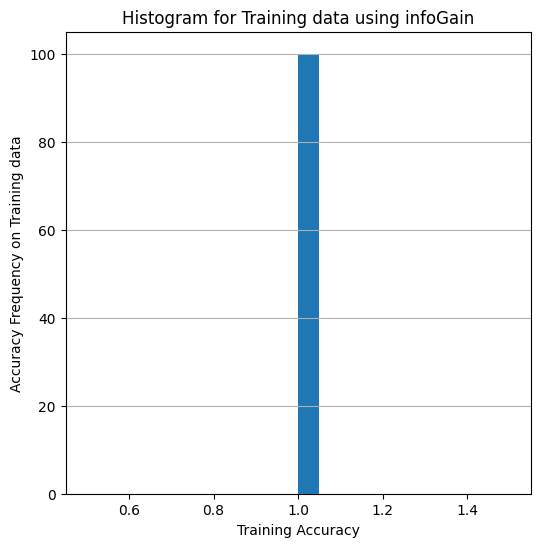

Using criteria: infoGain
Mean Testing Accuracy 0.9367816091954022
Std Deviation on Testing Data 0.02284437576362275


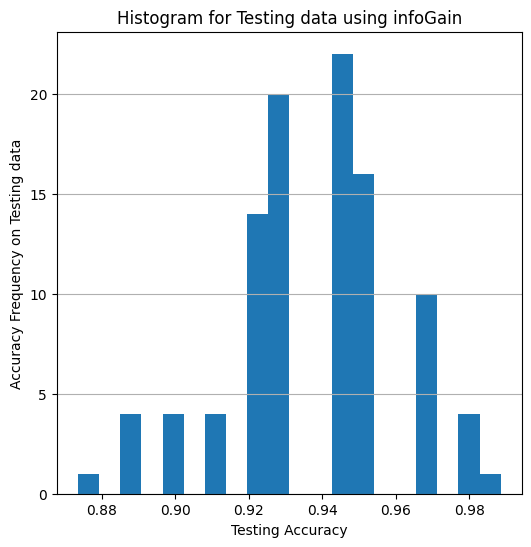

Using criteria: giniIndex
Mean Training Accuracy 1.0
Std Deviation on Training Data 0.0


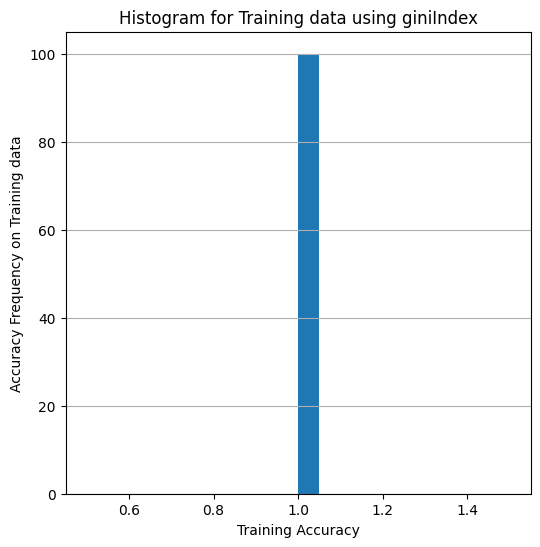

Using criteria: giniIndex
Mean Testing Accuracy 0.9370114942528734
Std Deviation on Testing Data 0.02272725110797804


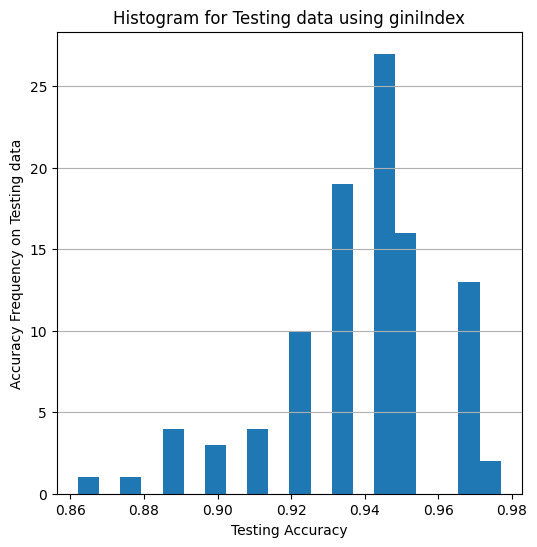

Using criteria: infoGain
Mean Training Accuracy 0.9629597701149426
Std Deviation on Training Data 0.004523375525658068


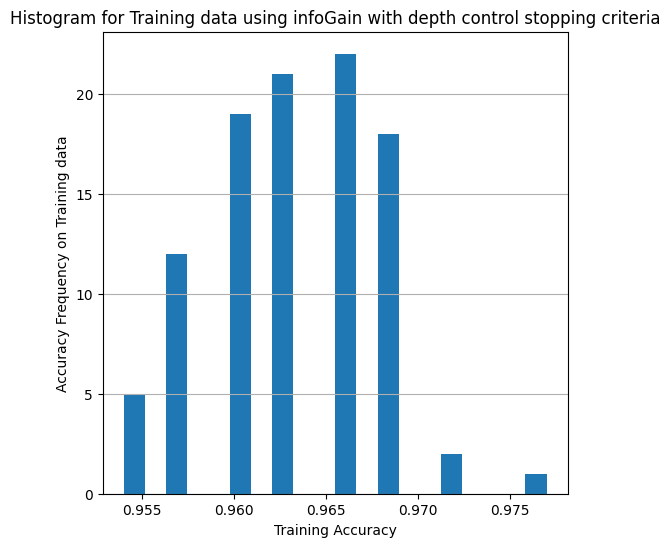

Using criteria: infoGain
Mean Testing Accuracy 0.9539080459770113
Std Deviation on Testing Data 0.019404191769077248


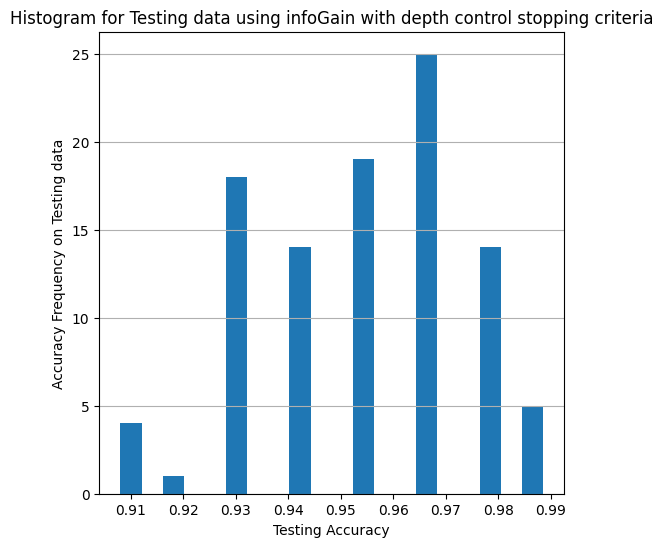

In [160]:
DecisionTree(voteData, "Training", "infoGain", depthControl=False)
DecisionTree(voteData, "Testing", "infoGain", depthControl=False)
DecisionTree(voteData, "Training", "giniIndex", depthControl=False)
DecisionTree(voteData, "Testing", "giniIndex", depthControl=False)
DecisionTree(voteData, "Training", "infoGain", depthControl=True)
DecisionTree(voteData, "Testing", "infoGain", depthControl=True)